# Прогнозирование оттока клиентов (client loss)


## Изучение и предобработка данных

**Изучим данные из файла**

Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

Импортируем данные.

### Информация о договоре: contract.csv

In [2]:
contract = pd.read_csv('contract.csv', parse_dates=['BeginDate'])

print('Посмотрим на первые 5 строк датафрейма contract:')
display(contract.head())
print('')
print('')
print('Посмотрим общую информацию о датафрейме применив метод .info()')
display(contract.info())

Посмотрим на первые 5 строк датафрейма contract:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65




Посмотрим общую информацию о датафрейме применив метод .info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


None

**Датафрейм содержат 8 столбцов, 7043 записи:**

    - customerID - уникальный код клиента
    - BeginDate - дата начала пользования услугами
    - EndDate - дата окончания пользования услугами (целевой признак)
    - Type - тип оплаты: ежемесячный, годовой и один раз в 2 года
    - PaperlessBilling - безналичный расчет
    - PaymentMethod - способ оплаты
    - MonthlyCharges - ежемесячные траты на услуги
    - TotalCharges - всего потрачено денег на услуги
    
Проверим датафрейм на наличие задублированных записей.

In [3]:
contract.duplicated().sum()

0

Дублей нет.

Первый столбец указывает на уникальный код клиента. Проверим этот столбец отдельно на наличие дубликатов.

In [4]:
contract['customerID'].duplicated().sum()

0

Задублированные коды клиента также отсутствуют.

Посмотрим, какие значения принимают столбцы 'Type', 'PaperlessBilling', 'PaymentMethod'.

In [5]:
contract['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

Значения могут быть:

    - Month-to-month - оплата услуг по договору за каждый месяц отдельно
    - Two year - оплата услуг по договору за два года сразу
    - One year - оплата услуг по договору за год

In [6]:
contract['PaperlessBilling'].value_counts()

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

Значения понятны - Да или Нет.

In [7]:
contract['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

В столбце Метод оплаты есть четыре вида значений:

    - Электронный чек,
    - Почтовый чек,
    - Банковский автоматический перевод,
    - Кредитная карта (автоматическая оплата).
    
Посмотрим, какие значения принимает столбец 'contract' и сделаем выводы о временных рамках, в которых собрали данные о клиентах.

In [8]:
contract['BeginDate'].sort_values()

4513   2013-10-01
4610   2013-10-01
3439   2013-10-01
975    2013-11-01
3040   2013-11-01
          ...    
3331   2020-02-01
6670   2020-02-01
936    2020-02-01
3826   2020-02-01
6754   2020-02-01
Name: BeginDate, Length: 7043, dtype: datetime64[ns]

Самый первый договор, попавший в данные для исследования, был заключен в октябре 2013 года. Данные собраны до февраля 2020 года включительно.

Посмотрим на данные в столбце 'TotalCharges', для этого отсортируем их и выведем несколько первых значений.

UPD: Путем теста и анализа удалось выяснить, что существует 11 не числовых значений, которые в свою очередь не дают нам привести формат данного столбца к числовому.

Выведем эти значения.

In [9]:
contract['TotalCharges'].sort_values().head(11)

936      
3826     
4380     
753      
5218     
3331     
6754     
6670     
1340     
488      
1082     
Name: TotalCharges, dtype: object

Также, путем тестирования удалось выяснить, что это значение: ' ', иными словами один Space.

Посмотрим на датафрейм, где значение в столбце 'TotalCharges' равно ' '.

In [10]:
contract[contract['TotalCharges'].isin([' '])]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Сохраним список customerID с новыми клиентами.

    - 4472-LVYGI
    - 3115-CZMZD
    - 5709-LVOEQ
    - 4367-NUYAO
    - 1371-DWPAZ
    - 7644-OMVMY
    - 3213-VVOLG
    - 2520-SGTTA
    - 2923-ARZLG
    - 4075-WKNIU
    - 2775-SEFEE

Мы видим, что в столбце 'BeginDate' указан последний месяц, за который, как мы уже выяснили выше, собраны наши данные - февраль 2020 года. При этом значение в столбце 'EndDate' равно 'No'.

Проведем оценку: а сколько всего строк содержит значение 2020-02-01 в столбце 'BeginDate'.

In [11]:
contract[contract['BeginDate'].isin(['2020-02-01'])]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Это все те же самые 11 строк.

Мы можем убрать из исследования эти строки, как записи о клиентах, которые заключили договор в последний исследуемый месяц, и еще нет данных о них в будущем.

Затем приведем значения в столбце 'TotalCharges' к формату float64.

In [12]:
contract = contract.query('BeginDate < "2020-02-01"')

contract['TotalCharges'] = contract['TotalCharges'].astype('float64')

print('Посмотрим на первые 5 строк датафрейма contract:')
display(contract.head())
print('')
print('')
print('Посмотрим общую информацию о датафрейме применив метод .info()')
display(contract.info())

Посмотрим на первые 5 строк датафрейма contract:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65




Посмотрим общую информацию о датафрейме применив метод .info()
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   object        
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 494.4+ KB


None

- Столбец BeginDate привели к формату даты при загрузке файла.

- Необходимо провести исследовательский анализ данных и проверить данные на наличие выбросов аномалий.

### Персональные данные клиента: personal.csv

In [13]:
personal = pd.read_csv('personal.csv')

print('Посмотрим на первые 5 строк датафрейма personal:')
display(personal.head())
print('')
print('')
print('Посмотрим общую информацию о датафрейме применив метод .info()')
display(personal.info())

Посмотрим на первые 5 строк датафрейма personal:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No




Посмотрим общую информацию о датафрейме применив метод .info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

**Датафрейм содержит 5 столбцов, 7043 записи:**

    - customerID - уникальный код клиента
    - gender - пол
    - SeniorCitizen - наличие пенсионного статуса по возрасту
    - Partner - наличие супруга(и)
    - Dependents - наличие иждивенцев
    
Проверим датафрейм на наличие задублированных записей.

In [14]:
personal.duplicated().sum()

0

In [15]:
personal['customerID'].duplicated().sum()

0

Задублированных записей нет.

Посмотрим, какие значения принимают столбцы 'gender', 'SeniorCitizen', 'Partner' и 'Dependents'.

In [16]:
personal['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

Данные понятны - Male или Female

In [17]:
personal['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

Данные понятны.

In [18]:
personal['Partner'].value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

Данные понятны.

In [19]:
personal['Dependents'].value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

Данные понятны.

### Информация об интернет-услугах: internet.csv

In [20]:
internet = pd.read_csv('internet.csv')

print('Посмотрим на первые 5 строк датафрейма internet:')
display(internet.head())
print('')
print('')
print('Посмотрим общую информацию о датафрейме применив метод .info()')
display(internet.info())

Посмотрим на первые 5 строк датафрейма internet:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No




Посмотрим общую информацию о датафрейме применив метод .info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

**Датафрейм содержит 8 столбцов, 5517 записей:**

    - customerID - уникальный код клиента
    - InternetService - тип подключения интернета
    - OnlineSecurity - подключена ли услуга: Блокировка небезопасных сайтов (*OnlineSecurity*)
    - OnlineBackup - подключена ли услуга: Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*)
    - DeviceProtection - подключена ли услуга: Антивирус (*DeviceProtection*)
    - TechSupport - подключена ли услуга: Выделенная линия технической поддержки (*TechSupport*)
    - StreamingTV - подключена ли услуга: Стриминговое телевидение (*StreamingTV*)
    - StreamingMovies - подключена ли услуга: каталог фильмов (*StreamingMovies*)
    
Проверим датафрейм на наличие задублированных записей.

In [21]:
internet.duplicated().sum()

0

In [22]:
internet['customerID'].duplicated().sum()

0

Задублированные записи отсутствуют.

Посмотрим, какие значения принимают столбцы 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'.

In [23]:
internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

In [24]:
internet['OnlineSecurity'].value_counts()

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

In [25]:
internet['OnlineBackup'].value_counts()

No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

In [26]:
internet['DeviceProtection'].value_counts()

No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

In [27]:
internet['TechSupport'].value_counts()

No     3473
Yes    2044
Name: TechSupport, dtype: int64

In [28]:
internet['StreamingTV'].value_counts()

No     2810
Yes    2707
Name: StreamingTV, dtype: int64

In [29]:
internet['StreamingMovies'].value_counts()

No     2785
Yes    2732
Name: StreamingMovies, dtype: int64

Неожидаемые ответы не обнаружены. Данные понятны.

### Информация об услугах телефонии:  phone.csv

In [30]:
phone = pd.read_csv('phone.csv')

print('Посмотрим на первые 5 строк датафрейма phone:')
display(phone.head())
print('')
print('')
print('Посмотрим общую информацию о датафрейме применив метод .info()')
display(phone.info())

Посмотрим на первые 5 строк датафрейма phone:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes




Посмотрим общую информацию о датафрейме применив метод .info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

**Датафрейм содержит 2 столбца, 6361 запись:**

    - customerID - уникальный код клиента
    - MultipleLines - наличие возможности ведения параллельных линий во время звонка
    
Проверим датафрейм на наличие задублированных записей.

In [31]:
phone.duplicated().sum()

0

In [32]:
phone['customerID'].duplicated().sum()

0

Задублированных данных нет.

Посмотрим, нет ли неожиданных значений в столбце 'MultipleLines'.

In [33]:
phone['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

Данные понятны. Неожидаемых значений нет.

### Выводы первого этапа

    - Данные собраны с октября 2013 года по февраль 2020 года.
    - Перед нами стоит задача бинарной классификации, для которой целевым признаком будет являться значение в столбце
    'EndDate' датафрейма contract: ушел клиент или остался.
    - Будем использовать метрику AUC-ROC и также дополнительно посчитаем метрику Accuracy.
    - Приведем целевой признак к бинарному виду.
    - Клиенты, которые недавно заключили договор - их можно отсеять.

## Исследовательский анализ данных

### Работа с выбросами и аномалиями в данных

Посмотрим, в каких данных у нас могут быть выбросы.

В датафрейме **contract** столбец 'EndDate' - это целевой признак. Его трогать не будем.

Type, PaperlessBilling, PaymentMethod - это столбцы с категориальными признаками.

MonthlyCharges, TotalCharges - столбцы с численными признаками, исследуем данные в этих столбцах на выбросы. Оценим наличие выбросов с помощью графика "ящик с усами".

В теории: данные, находящиеся за пределами интервал (q3 + 1,5iqr) сверху и  до (q3 + 3iqr) - считаются выбросами на усмотрение бизнеса.

Данные, находящиеся за пределами (q3 + 3iqr) грубые выбросы, которые необходимо убрать.

Численное описание данных столбца MonthlyCharges:


count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: MonthlyCharges, dtype: float64

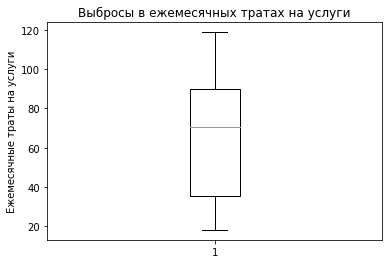

In [34]:
print('Численное описание данных столбца MonthlyCharges:')
display(contract['MonthlyCharges'].describe())

plt.boxplot(contract['MonthlyCharges'].values)
plt.ylabel('Ежемесячные траты на услуги')
plt.title("Выбросы в ежемесячных тратах на услуги")
plt.show() 

In [35]:
anomaly_MonthlyCharges_min = 35.587500 - (1.5 * (89.862500 - 35.587500))
display ('Выбросами снизу считаем значения в столбце MonthlyCharges меньше, чем:', anomaly_MonthlyCharges_min)
         
anomaly_MonthlyCharges_max = 89.862500 + 1.5 * (89.862500 - 35.587500)
display ('Выбросами на усмотрение бизнеса сверху считаем значения в столбце MonthlyCharges больше, чем:', anomaly_MonthlyCharges_max)

anomaly_MonthlyCharges_max = 89.862500 + 3 * (89.862500 - 35.587500)
display ('Грубыми выбросами считаем значения в столбце MonthlyCharges больше, чем:', anomaly_MonthlyCharges_max)

'Выбросами снизу считаем значения в столбце MonthlyCharges меньше, чем:'

-45.824999999999996

'Выбросами на усмотрение бизнеса сверху считаем значения в столбце MonthlyCharges больше, чем:'

171.27499999999998

'Грубыми выбросами считаем значения в столбце MonthlyCharges больше, чем:'

252.6875

У нас отсутствуют значения, выходящие за границы нормального размаха.

Посмотрим на значения в столбце 'TotalCharges'

Численное описание данных столбца TotalCharges:


count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

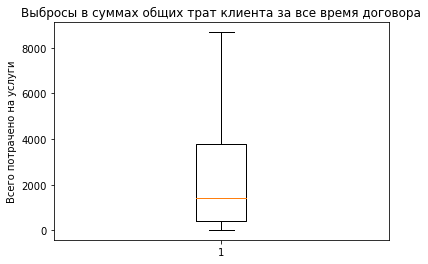

In [36]:
print('Численное описание данных столбца TotalCharges:')
display(contract['TotalCharges'].describe())

plt.boxplot(contract['TotalCharges'].values)
plt.ylabel('Всего потрачено на услуги')
plt.title("Выбросы в суммах общих трат клиента за все время договора")
plt.show()

In [37]:
anomaly_TotalCharges_min = 401.450000 - (1.5 * (3794.737500 - 401.450000))
display ('Выбросами снизу считаем значения в столбце TotalCharges меньше, чем:', anomaly_TotalCharges_min)
         
anomaly_TotalCharges_max = 3794.737500 + 1.5 * (3794.737500 - 401.450000)
display ('Выбросами на усмотрение бизнеса сверху считаем значения в столбце TotalCharges больше, чем:', anomaly_TotalCharges_max)

anomaly_TotalCharges_max = 3794.737500 + 3 * (3794.737500 - 401.450000)
display ('Грубыми выбросами считаем значения в столбце TotalCharges больше, чем:', anomaly_TotalCharges_max)

'Выбросами снизу считаем значения в столбце TotalCharges меньше, чем:'

-4688.481250000001

'Выбросами на усмотрение бизнеса сверху считаем значения в столбце TotalCharges больше, чем:'

8884.66875

'Грубыми выбросами считаем значения в столбце TotalCharges больше, чем:'

13974.600000000002

Выбросы в этом столбце также отсутствуют.

### Работа с целевым признаком

Создадим новый столбец с целевым признаком на базе 'EndDate'.

In [38]:
contract['EndDate'].value_counts()

No                     5163
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

Напишем функцию для заполнения столбца 'Сontract_no_terminated', где

    - 0: Договор расторгнут
    - 1: Клиент остался в компании, договор не расторгнут

In [39]:
def Сontract_no_terminated(row):
    if row['EndDate'] == 'No':
        return 0
    return 1

contract['Сontract_no_terminated'] = contract.apply(Сontract_no_terminated, axis=1)

In [40]:
print('Посмотрим на первые 5 строк датафрейма contract:')
display(contract.head())
print('')
print('')
print('Посмотрим общую информацию о датафрейме применив метод .info()')
display(contract.info())

Посмотрим на первые 5 строк датафрейма contract:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Сontract_no_terminated
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1




Посмотрим общую информацию о датафрейме применив метод .info()
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   customerID              7032 non-null   object        
 1   BeginDate               7032 non-null   datetime64[ns]
 2   EndDate                 7032 non-null   object        
 3   Type                    7032 non-null   object        
 4   PaperlessBilling        7032 non-null   object        
 5   PaymentMethod           7032 non-null   object        
 6   MonthlyCharges          7032 non-null   float64       
 7   TotalCharges            7032 non-null   float64       
 8   Сontract_no_terminated  7032 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 549.4+ KB


None

### Создание нового признака

Посмотрим, какие значения есть в столбце 'EndDate'.

In [41]:
contract['EndDate'].value_counts()

No                     5163
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

Для значения в столбце 'EndDate', где ранее у нас было заполнено 'No', укажем дату выгрузки данных - 1 февраля 2020 года.

In [42]:
contract.loc[contract['EndDate'] == 'No', 'EndDate'] = datetime.datetime(year=2020, month=2, day=1, hour=00, minute=00)
contract['EndDate']

0       2020-02-01 00:00:00
1       2020-02-01 00:00:00
2       2019-12-01 00:00:00
3       2020-02-01 00:00:00
4       2019-11-01 00:00:00
               ...         
7038    2020-02-01 00:00:00
7039    2020-02-01 00:00:00
7040    2020-02-01 00:00:00
7041    2019-11-01 00:00:00
7042    2020-02-01 00:00:00
Name: EndDate, Length: 7032, dtype: object

Приведем формат столбца 'EndDate' к формату даты.

In [43]:
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d %H:%M:%S')

print('Посмотрим на первые 5 строк датафрейма contract:')
display(contract.head())
print('')
print('')
print('Посмотрим общую информацию о датафрейме применив метод .info()')
display(contract.info())

Посмотрим на первые 5 строк датафрейма contract:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Сontract_no_terminated
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1




Посмотрим общую информацию о датафрейме применив метод .info()
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   customerID              7032 non-null   object        
 1   BeginDate               7032 non-null   datetime64[ns]
 2   EndDate                 7032 non-null   datetime64[ns]
 3   Type                    7032 non-null   object        
 4   PaperlessBilling        7032 non-null   object        
 5   PaymentMethod           7032 non-null   object        
 6   MonthlyCharges          7032 non-null   float64       
 7   TotalCharges            7032 non-null   float64       
 8   Сontract_no_terminated  7032 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 549.4+ KB


None

Добавим новый признак - Длительность контракта.

In [44]:
contract['Contract_duration'] = (contract['EndDate'] - contract['BeginDate']).dt.days

Посмотрим, какие значения принимает новый признак.

In [45]:
contract['Contract_duration'].value_counts()

31      431
2191    362
30      182
92      169
2163    164
       ... 
2070      2
1400      2
1552      2
1917      1
2161      1
Name: Contract_duration, Length: 155, dtype: int64

Новый признак создан.

### Оценим баланс классов

In [46]:
contract['Сontract_no_terminated'].value_counts()

0    5163
1    1869
Name: Сontract_no_terminated, dtype: int64

Наблюдается дисбаланс классов, который нужно будет учесть.

### Выводы второго этапа

    - Выбросы в данных не наблюдаются.
    - Присутствует дисбаланс классов в столбце с целевым признаком.

На следующем этапе сформируем список столбцов из всех датафреймов, которые войдут в итоговый датафрейм.

Датафрейм разделим на обучающую и тестовую выборку в пропорциях 80/20.

## Слияние датафреймов

В единый датафрейм возьмем следующие данные:

Из датафрейма **contract** возьмем столбцы:

    - customerID - уникальный код клиента
    - Type - тип оплаты: ежемесячный, годовой и один раз в 2 года
    - PaperlessBilling - безналичный расчет
    - PaymentMethod - способ оплаты
    - MonthlyCharges - ежемесячные траты на услуги
    - Сontract_no_terminated - остался ли клиент в компании или договор расторгнут (целевой признак)
    - Contract_duration - длительность контракта в днях на момент выгрузки данных

Из датафрейма **personal** возьмем столбцы:

    - gender - пол
    - SeniorCitizen - наличие пенсионного статуса по возрасту
    - Partner - наличие супруга(и)
    - Dependents - наличие иждивенцев
    
Из датафрейма **internet** возьмем столбцы:

    - InternetService - тип подключения интернета

*Столбцы в датафрейме **internet** малоинформативны.*

Из датафрейма **phone** возьмем столбец:

    - MultipleLine - наличие возможности ведения параллельных линий во время звонка.
    
Слияние датафреймов будем производить методом pd.concate.

### Подготовка датафреймов к слиянию

    - уберем ненужные столбцы
    - столбец 'customerID' сделаем индексом

In [47]:
contract = contract.drop(['BeginDate', 'EndDate', 'TotalCharges'], axis=1)
contract.set_index('customerID', inplace=True)

print('Посмотрим на первые 5 строк сводного датафрейма')
display(contract.head())

Посмотрим на первые 5 строк сводного датафрейма


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,Сontract_no_terminated,Contract_duration
customerID,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,0,31
5575-GNVDE,One year,No,Mailed check,56.95,0,1036
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,1,61
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,0,1371
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,1,61


In [48]:
personal.set_index('customerID', inplace=True)

internet = internet.drop(['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'], axis=1)
internet.set_index('customerID', inplace=True)

phone.set_index('customerID', inplace=True)

### Слияние

In [49]:
data = pd.concat([contract, personal, internet, phone], axis=1)

print('Посмотрим на первые 5 строк сводного датафрейма')
display(data.head())
print('')
print('')
print('Посмотрим общую информацию о датафрейме')
display(data.info())

Посмотрим на первые 5 строк сводного датафрейма


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,Сontract_no_terminated,Contract_duration,gender,SeniorCitizen,Partner,Dependents,InternetService,MultipleLines
customerID,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,0.0,31.0,Female,0,Yes,No,DSL,NaN
5575-GNVDE,One year,No,Mailed check,56.95,0.0,1036.0,Male,0,No,No,DSL,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,1.0,61.0,Male,0,No,No,DSL,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,0.0,1371.0,Male,0,No,No,DSL,NaN
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,1.0,61.0,Female,0,No,No,Fiber optic,No




Посмотрим общую информацию о датафрейме
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 2775-SEFEE
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Type                    7032 non-null   object 
 1   PaperlessBilling        7032 non-null   object 
 2   PaymentMethod           7032 non-null   object 
 3   MonthlyCharges          7032 non-null   float64
 4   Сontract_no_terminated  7032 non-null   float64
 5   Contract_duration       7032 non-null   float64
 6   gender                  7043 non-null   object 
 7   SeniorCitizen           7043 non-null   int64  
 8   Partner                 7043 non-null   object 
 9   Dependents              7043 non-null   object 
 10  InternetService         5517 non-null   object 
 11  MultipleLines           6361 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 715.3+ KB


None

### Пустые значения

Пропуски в столбцах 'InternetService' и 'MultipleLines' указывают на то, что клиенты не пользуются данной услугой. Заполним пропуски значением service_is_not_provided.

In [50]:
data['InternetService'] = data['InternetService'].fillna('service_is_not_provided')
data['MultipleLines'] = data['MultipleLines'].fillna('service_is_not_provided')

print('Посмотрим общую информацию о датафрейме')
display(data.info())

Посмотрим общую информацию о датафрейме
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 2775-SEFEE
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Type                    7032 non-null   object 
 1   PaperlessBilling        7032 non-null   object 
 2   PaymentMethod           7032 non-null   object 
 3   MonthlyCharges          7032 non-null   float64
 4   Сontract_no_terminated  7032 non-null   float64
 5   Contract_duration       7032 non-null   float64
 6   gender                  7043 non-null   object 
 7   SeniorCitizen           7043 non-null   int64  
 8   Partner                 7043 non-null   object 
 9   Dependents              7043 non-null   object 
 10  InternetService         7043 non-null   object 
 11  MultipleLines           7043 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 715.3+ KB


None

У нас есть разница в количестве записей: 11 записей о новых клиентах.

Их также нужно убрать.

Мы знаем их ID:

    4472-LVYGI
    3115-CZMZD
    5709-LVOEQ
    4367-NUYAO
    1371-DWPAZ
    7644-OMVMY
    3213-VVOLG
    2520-SGTTA
    2923-ARZLG
    4075-WKNIU
    2775-SEFEE

In [51]:
data.drop(labels = ['4472-LVYGI', '3115-CZMZD', '5709-LVOEQ', '4367-NUYAO', '1371-DWPAZ', '7644-OMVMY',
                    '3213-VVOLG', '2520-SGTTA', '2923-ARZLG', '4075-WKNIU', '2775-SEFEE'],axis = 0, inplace = True)

print('Посмотрим общую информацию о датафрейме')
display(data.info())

Посмотрим общую информацию о датафрейме
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Type                    7032 non-null   object 
 1   PaperlessBilling        7032 non-null   object 
 2   PaymentMethod           7032 non-null   object 
 3   MonthlyCharges          7032 non-null   float64
 4   Сontract_no_terminated  7032 non-null   float64
 5   Contract_duration       7032 non-null   float64
 6   gender                  7032 non-null   object 
 7   SeniorCitizen           7032 non-null   int64  
 8   Partner                 7032 non-null   object 
 9   Dependents              7032 non-null   object 
 10  InternetService         7032 non-null   object 
 11  MultipleLines           7032 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 714.2+ KB


None

**Данные готовы к дальнейшему этапу.**

### Преобразование категориальных признаков

Преобразовать категориальные признаки в численные поможет техника прямого кодирования, или отображения.

Но для начала, сохраним версию датафрейма в переменной data_old для того, чтобы в будущем поработать с моделями градиентного бустинга.

In [52]:
data_old = data
print('Посмотрим на первые 5 строк датафрейма data_old:')
display(data_old.head())
print('')
print('')
print('Посмотрим общую информацию о датафрейме применив метод .info()')
display(data_old.info())

Посмотрим на первые 5 строк датафрейма data_old:


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,Сontract_no_terminated,Contract_duration,gender,SeniorCitizen,Partner,Dependents,InternetService,MultipleLines
customerID,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,0.0,31.0,Female,0,Yes,No,DSL,service_is_not_provided
5575-GNVDE,One year,No,Mailed check,56.95,0.0,1036.0,Male,0,No,No,DSL,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,1.0,61.0,Male,0,No,No,DSL,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,0.0,1371.0,Male,0,No,No,DSL,service_is_not_provided
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,1.0,61.0,Female,0,No,No,Fiber optic,No




Посмотрим общую информацию о датафрейме применив метод .info()
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Type                    7032 non-null   object 
 1   PaperlessBilling        7032 non-null   object 
 2   PaymentMethod           7032 non-null   object 
 3   MonthlyCharges          7032 non-null   float64
 4   Сontract_no_terminated  7032 non-null   float64
 5   Contract_duration       7032 non-null   float64
 6   gender                  7032 non-null   object 
 7   SeniorCitizen           7032 non-null   int64  
 8   Partner                 7032 non-null   object 
 9   Dependents              7032 non-null   object 
 10  InternetService         7032 non-null   object 
 11  MultipleLines           7032 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 714.2+ KB


None

In [53]:
data = pd.get_dummies(data, drop_first = True)

print('Посмотрим на первые 5 строк датафрейма data:')
display(data.head())

Посмотрим на первые 5 строк датафрейма data:


,MonthlyCharges,Сontract_no_terminated,Contract_duration,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_service_is_not_provided,MultipleLines_Yes,MultipleLines_service_is_not_provided
customerID,,,,,,,,,,,,,,,,,
7590-VHVEG,29.85,0.0,31.0,0,0,0,1,0,1,0,0,1,0,0,0,0,1
5575-GNVDE,56.95,0.0,1036.0,0,1,0,0,0,0,1,1,0,0,0,0,0,0
3668-QPYBK,53.85,1.0,61.0,0,0,0,1,0,0,1,1,0,0,0,0,0,0
7795-CFOCW,42.30,0.0,1371.0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
9237-HQITU,70.70,1.0,61.0,0,0,0,1,0,1,0,0,0,0,1,0,0,0


В результате мы получили 17 столбцов, не считая индекса, указывающего на уникальный код клиента.

Также мы исключили возможность образования дамми-ловушек.

Изменим названия столбцов для понятного общего восприятия.

In [54]:
data.rename(columns = {'Type_One year' : 'Type_One_year',
                       'Type_Two year' : 'Type_Two_year',
                       'PaperlessBilling_Yes' : 'PaperlessBilling',
                       'PaymentMethod_Credit card (automatic)' : 'Credit_card',
                       'PaymentMethod_Electronic check' : 'Electronic_check',
                       'PaymentMethod_Mailed check' : 'Mailed_check',
                       'gender_Male' : 'Male_gender',
                       'Partner_Yes' : 'Partner',
                       'Dependents_Yes' : 'Dependents',
                       'InternetService_Fiber optic' : 'Fiber_optic',
                       'MultipleLines_Yes' : 'MultipleLines',
                       'InternetService_service_is_not_provided' : 'Is_is_not_provided',
                       'MultipleLines_service_is_not_provided' : 'Ms_is_not_provided'}, inplace = True)

print('Посмотрим на первые 5 строк датафрейма data:')
display(data.head())
print('')
print('')
print('Посмотрим общую информацию о датафрейме применив метод .info()')
display(data.info())

Посмотрим на первые 5 строк датафрейма data:


,MonthlyCharges,Сontract_no_terminated,Contract_duration,SeniorCitizen,Type_One_year,Type_Two_year,PaperlessBilling,Credit_card,Electronic_check,Mailed_check,Male_gender,Partner,Dependents,Fiber_optic,Is_is_not_provided,MultipleLines,Ms_is_not_provided
customerID,,,,,,,,,,,,,,,,,
7590-VHVEG,29.85,0.0,31.0,0,0,0,1,0,1,0,0,1,0,0,0,0,1
5575-GNVDE,56.95,0.0,1036.0,0,1,0,0,0,0,1,1,0,0,0,0,0,0
3668-QPYBK,53.85,1.0,61.0,0,0,0,1,0,0,1,1,0,0,0,0,0,0
7795-CFOCW,42.30,0.0,1371.0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
9237-HQITU,70.70,1.0,61.0,0,0,0,1,0,1,0,0,0,0,1,0,0,0




Посмотрим общую информацию о датафрейме применив метод .info()
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   MonthlyCharges          7032 non-null   float64
 1   Сontract_no_terminated  7032 non-null   float64
 2   Contract_duration       7032 non-null   float64
 3   SeniorCitizen           7032 non-null   int64  
 4   Type_One_year           7032 non-null   uint8  
 5   Type_Two_year           7032 non-null   uint8  
 6   PaperlessBilling        7032 non-null   uint8  
 7   Credit_card             7032 non-null   uint8  
 8   Electronic_check        7032 non-null   uint8  
 9   Mailed_check            7032 non-null   uint8  
 10  Male_gender             7032 non-null   uint8  
 11  Partner                 7032 non-null   uint8  
 12  Dependents              7032 non-null   uint8  
 13  Fiber_optic       

None

    - MonthlyCharges - сумма ежемесячных трат на услуги
    - Сontract_no_terminated - где 1: договор не расторгнут, 0: договор расторгнут
    - Contract_duration - длительность контракта в днях на момент сбора данных
    - SeniorCitizen - где 1: наличие пенсионного статуса по возрасту, 0: отсутствие
    - Type_One_year - где 1: годовой тип оплаты
    - Type_Two_year - где 1: тип оплаты раз в два года (если в обоих столбцах 0, значит тип оплаты ежемесячный)
    - PaperlessBilling - где 1: безналичный расчет
    - Credit_card - где 1: способ оплаты Credit card (automatic)
    - Electronic_check - где 1: способ оплаты Electronic check
    - Mailed_check - где 1: способ оплаты Mailed check (если в трех столбцах 0, значит способ оплаты Bank transfer)
    - Male_gender - где 1: мужской пол, 0: женский
    - Partner - где 1: наличие супруга(и), 0: отсутствие
    - Dependents - где 1: наличие иждивенцев, 0: отсутствие
    - Fiber_optic optic - где 1: тип подключения интернета Fiber optic, 0: DSL
    - Is_is_not_provided - где 1: услуга интернет не предоставляется
    - MultipleLines - где 1: наличие возможности ведения параллельных линий во время звонка, 0: отсутствие
    - Ms_is_not_provided - где 1: услуга телефонии не предоставляется

### Корреляция между признаками

Рассчитаем коэффициент корреляции Пирсона и построим тепловую карту матрицы коррелляции.

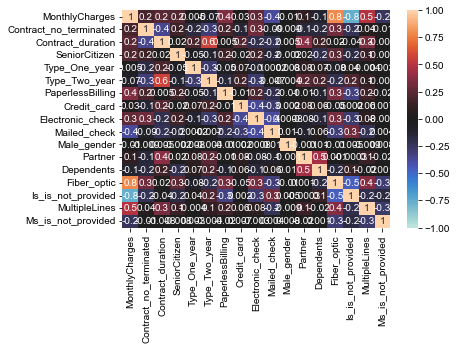

In [55]:
sns.heatmap(data.corr(), annot = True, fmt = '.1g', vmin = -1, vmax = 1, center = 0)
sns.set(rc = {'figure.figsize':(16, 8)})

По карте мы видим, прослеживается достаточно сильная корреляция между парами признаков: Fiber_optic и MonthlyCharges: 0,8 по модулю. И соответственно Is_is_not_provided и MonthlyCharges: 0,8 по модулю.

Между парой признаков Fiber_optic и Is_is_not_provided присутствует ожидаемая корреляция: 0,5 по модулю.

Аналогичная коореляция наблюдается между признаками MonthlyCharges и MultipleLines: 0,5 по модулю.

Предлагаем следующее решение: убрать из числа признаков 'MonthlyCharges'. Затем проверит снова корреляция между признаками.

In [56]:
data = data.drop(['MonthlyCharges'], axis = 1)

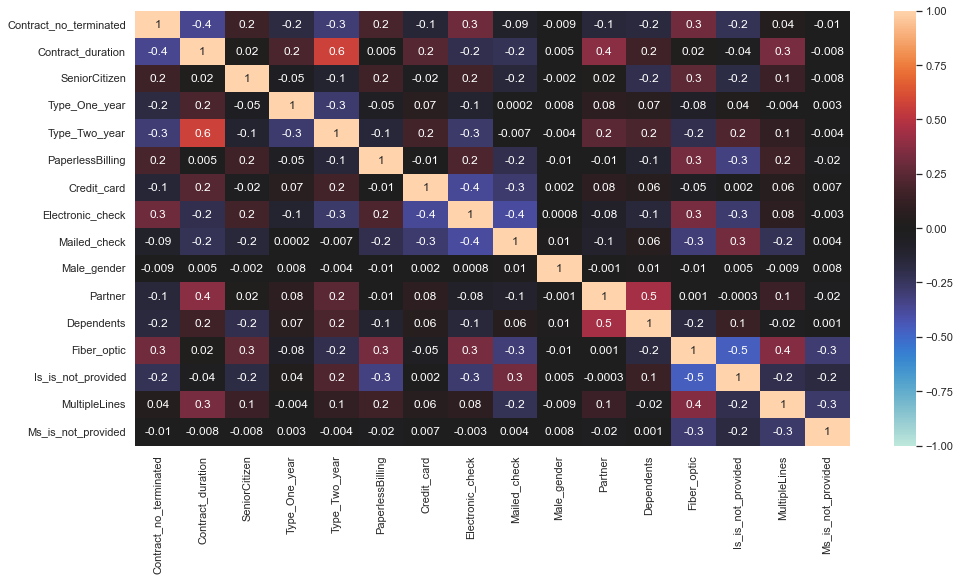

In [57]:
sns.heatmap(data.corr(), annot = True, fmt = '.1g', vmin = -1, vmax = 1, center = 0)
sns.set(rc = {'figure.figsize':(16, 8)})

Данные готовы к разбиению на обучающую и тестовую выборку.

## Обучающая и тестовая выборка

Приготовим две выборки: обучающую и тестовую в соотношении 80/20.

Целевой признак: 'Сontract_no_terminated'.

Таким образом мы получим 2 пары:

    features_train и target_train
    features_test и target_test

После разбиения выведем размеры полученных выборок для проверки корректности разбиения с точки зрения размеров выборок.

In [58]:
features = data.drop(['Сontract_no_terminated'], axis=1)
target = data['Сontract_no_terminated']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

Посмотрим на размер сформировавшихся выборок.

In [59]:
display('Размер обучающей выборки features_train:', features_train.shape)
display('Размер обучающей выборки с целевым признаком target_train:', target_train.shape)

display('Размер тестовой выборки features_train:', features_test.shape)
display('Размер тестовой выборки с целевым признаком target_train:', target_test.shape)

'Размер обучающей выборки features_train:'

(5625, 15)

'Размер обучающей выборки с целевым признаком target_train:'

(5625,)

'Размер тестовой выборки features_train:'

(1407, 15)

'Размер тестовой выборки с целевым признаком target_train:'

(1407,)

Выборки сформировались корректно относительно заданных процентов.

### Стандартизация численных признаков

Поработаем со столбцом: 'Contract_duration'.

Создадим объект структуры StandardScaler() и настроим его на обучающих данных.

Затем перезапишем преобразованные обучающую и тестовую выборки.

In [60]:
numeric = ['Contract_duration']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.head())
print('')
print('')
print('Посмотрим общую информацию о датафрейме применив метод .info()')
display(features_train.info())

            Contract_duration  SeniorCitizen  Type_One_year  Type_Two_year  \
customerID                                                                   
5624-RYAMH          -0.954408              0              0              0   
8952-WCVCD           0.344473              0              1              0   
4088-YLDSU           0.915071              0              1              0   
4522-XRWWI           0.385898              0              1              0   
7463-IFMQU           1.604601              0              0              1   

            PaperlessBilling  Credit_card  Electronic_check  Mailed_check  \
customerID                                                                  
5624-RYAMH                 1            0                 1             0   
8952-WCVCD                 1            0                 0             0   
4088-YLDSU                 1            0                 1             0   
4522-XRWWI                 0            1                 0         

None

## Машинное обучение (классические модели)

### Метрики качества

Введем функцию model_metrics для получения оценок работы моделей машинного обучения, где:

    - Полнота - доля положительных ответов среди всех ответов
    - Точность - доля найденных отрицательных ответов, пока осуществлялся поиск положительных ответов
    - F1-мера - среднее гармоническое полноты и точности
    - AUC-ROC - площадь под ROC-кривой (кривой ошибок)
    
Но главной метрикой для нас будет AUC-ROC, чем она больше, тем лучше.

In [61]:
def model_metrics(target_test, prediction, probabilities_one_test):
    print('Полнота:', recall_score(target_test, prediction))
    print('Точность:', precision_score(target_test, prediction))
    print('Accuracy:', accuracy_score(target_test, prediction))
    print('F1-мера:', f1_score(target_test, prediction))
    print('AUC-ROC:', roc_auc_score(target_test, prediction))
    print('AUC-ROC (predict_proba):', roc_auc_score(target_test, probabilities_one_test))

### Модели машинного обучения (классические)

Рассмотрим 3 алгоритма классификации.

In [62]:
model_DT = DecisionTreeClassifier(random_state = 12345, class_weight="balanced")
model_DT.fit(features_train, target_train)
predictions_test_DT = model_DT.predict(features_test)
probabilities_test = model_DT.predict_proba(features_test)
probabilities_one_test_DT = probabilities_test[:, 1]

model_RF = RandomForestClassifier(random_state = 12345, class_weight="balanced")
model_RF.fit(features_train, target_train)
predictions_test_RF = model_RF.predict(features_test)
probabilities_test = model_RF.predict_proba(features_test)
probabilities_one_test_RF = probabilities_test[:, 1]

model_LR = LogisticRegression(random_state = 12345, solver = 'liblinear', class_weight="balanced")
model_LR.fit(features_train, target_train)
predictions_test_LR = model_LR.predict(features_test)
probabilities_test = model_LR.predict_proba(features_test)
probabilities_one_test_LR = probabilities_test[:, 1]

### Расчет метрик на базовых моделях

Посчитаем метрики для 3 алгоритмов классификации:

In [63]:
model_metrics(target_test, predictions_test_DT, probabilities_one_test_DT)

auc_roc = roc_auc_score(target_test, probabilities_one_test_DT)
DecisionTreeClassifier_data = pd.DataFrame({'model': ['DecisionTreeClassifier'], 'AUC-ROC': [auc_roc]})
display (DecisionTreeClassifier_data)

Полнота: 0.587467362924282
Точность: 0.6446991404011462
Accuracy: 0.7995735607675906
F1-мера: 0.6147540983606558
AUC-ROC: 0.733186806462141
AUC-ROC (predict_proba): 0.7356524355417754


,model,AUC-ROC
0,DecisionTreeClassifier,0.735652


In [64]:
model_metrics(target_test, predictions_test_RF, probabilities_one_test_RF)

auc_roc = roc_auc_score(target_test, probabilities_one_test_RF)
RandomForestClassifier_data = pd.DataFrame({'model': ['RandomForestClassifier'], 'AUC-ROC': [auc_roc]})
display (RandomForestClassifier_data)

Полнота: 0.5065274151436031
Точность: 0.6423841059602649
Accuracy: 0.7889125799573561
F1-мера: 0.5664233576642335
AUC-ROC: 0.7005293325718016
AUC-ROC (predict_proba): 0.8205955246409922


,model,AUC-ROC
0,RandomForestClassifier,0.820596


In [65]:
model_metrics(target_test, predictions_test_LR, probabilities_one_test_LR)

auc_roc = roc_auc_score(target_test, probabilities_one_test_LR)
LogisticRegression_data = pd.DataFrame({'model': ['LogisticRegression'], 'AUC-ROC': [auc_roc]})
display (LogisticRegression_data)

Полнота: 0.7885117493472585
Точность: 0.5189003436426117
Accuracy: 0.7434257285003554
F1-мера: 0.6259067357512954
AUC-ROC: 0.7575371246736293
AUC-ROC (predict_proba): 0.8460792163022194


,model,AUC-ROC
0,LogisticRegression,0.846079


Модели имеют недостаточное качество.

Значения F1-мера и AUC-ROC выше всего у модели **LogisticRegression**.

Поработаем с этими двумя моделями.

### AUC-ROC. Логистическая регрессия

Изменим значение порога и посмотрим, какими станут метрики.

Будем использовать функцию для вычисления вероятности классов **predict_proba()**.

In [66]:
predictions_one_test_LR = model_LR.predict_proba(features_test)[:, 1]

print('AUC-ROC:', roc_auc_score(target_test, predictions_one_test_LR))

AUC-ROC: 0.8460792163022194


Переберем значения порогов от 0 до 0.3 с шагом 0.02. Найдем для каждого значения точность и полноту.

In [67]:
for threshold in np.arange(0, 0.3, 0.02):
    predicted_test = predictions_one_test_LR > threshold
    precision = precision_score(target_test, predicted_test)
    recall = recall_score(target_test, predicted_test)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(threshold, precision, recall))

Порог = 0.00 | Точность = 0.272, Полнота = 1.000
Порог = 0.02 | Точность = 0.281, Полнота = 1.000
Порог = 0.04 | Точность = 0.301, Полнота = 0.997
Порог = 0.06 | Точность = 0.314, Полнота = 0.992
Порог = 0.08 | Точность = 0.328, Полнота = 0.987
Порог = 0.10 | Точность = 0.343, Полнота = 0.984
Порог = 0.12 | Точность = 0.356, Полнота = 0.979
Порог = 0.14 | Точность = 0.363, Полнота = 0.971
Порог = 0.16 | Точность = 0.372, Полнота = 0.969
Порог = 0.18 | Точность = 0.387, Полнота = 0.966
Порог = 0.20 | Точность = 0.398, Полнота = 0.958
Порог = 0.22 | Точность = 0.407, Полнота = 0.958
Порог = 0.24 | Точность = 0.414, Полнота = 0.953
Порог = 0.26 | Точность = 0.419, Полнота = 0.945
Порог = 0.28 | Точность = 0.428, Полнота = 0.935


Мы видим, как с увеличением значения порога, повышается значение точности и уменьшается полнота.

### ROC-кривая

Построим ROC-кривую. По горизонтали нанесём долю ложноположительных ответов (FPR), а по вертикали — долю истинно положительных ответов (TPR). Переберём значения порога логистической
регрессии и проведём кривую.

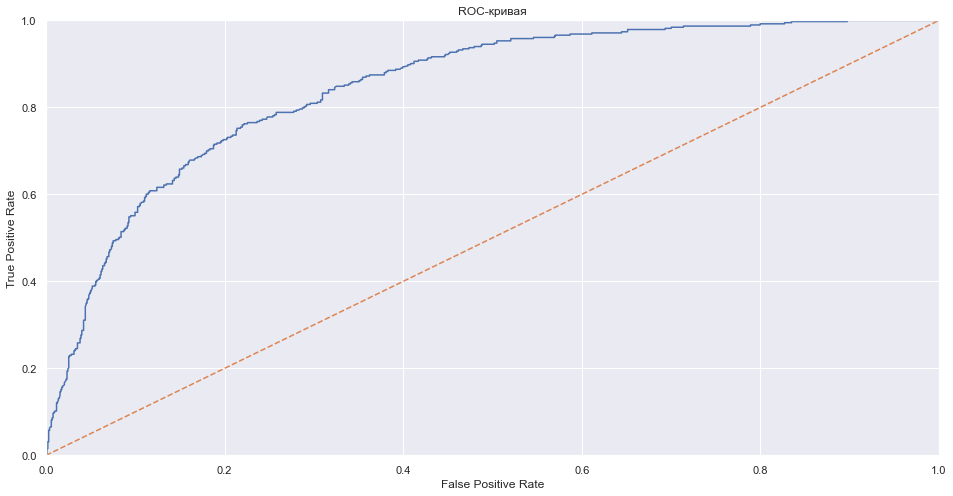

In [68]:
fpr, tpr, thresholds = roc_curve(target_test, predictions_one_test_LR) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### Pipeline

Запустим пайплайн с двумя моделями: LogisticRegression и RandomForestClassifier.

Определим «сетку» параметров, которые мы хотим протестировать в модели, и выберем лучшую модель, используя GridSearchCV.

In [69]:
pipe = Pipeline([('classifier' , RandomForestClassifier())])

param_grid = [{'classifier': [LogisticRegression()],
               'classifier__penalty' : ['l1', 'l2'],
               'classifier__class_weight' : ['balanced'],
               'classifier__random_state' : [12345],
               'classifier__C' : np.logspace(0.1, 1, 10),
               'classifier__solver' : ['liblinear']},
              {'classifier': [RandomForestClassifier()],
               'classifier__class_weight' : ['balanced'],
               'classifier__random_state' : [12345],
               'classifier__n_estimators' : list(range(10, 201, 10))
              }]

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 10, verbose = True, n_jobs = -1)

best_clf = clf.fit(features_train, target_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


In [70]:
best_clf.best_estimator_.get_params()['classifier']

RandomForestClassifier(class_weight='balanced', n_estimators=90,
                       random_state=12345)

In [71]:
model_RF = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                              criterion='gini', max_depth=None, max_features='auto',
                              max_leaf_nodes=None, min_impurity_decrease=0.0,
                              min_impurity_split=None, min_samples_leaf=1,
                                  min_samples_split=2, min_weight_fraction_leaf=0.0,
                                  n_estimators=90, n_jobs=None, oob_score=False,
                                  random_state=12345, verbose=0, warm_start=False)

model_RF.fit(features_train, target_train)
predictions_test_RF = model_RF.predict(features_test)
probabilities_test = model_RF.predict_proba(features_test)
probabilities_one_test_RF = probabilities_test[:, 1]

In [72]:
model_metrics(target_test, predictions_test_RF, probabilities_one_test_RF)

auc_roc = roc_auc_score(target_test, probabilities_one_test_RF)
RandomForestClassifier_pipeline_data = pd.DataFrame({'model': ['RandomForestClassifier_pipeline'], 'AUC-ROC': [auc_roc]})
display (RandomForestClassifier_pipeline_data)

Полнота: 0.5065274151436031
Точность: 0.6466666666666666
Accuracy: 0.7903340440653873
F1-мера: 0.568081991215227
AUC-ROC: 0.7015058950718016
AUC-ROC (predict_proba): 0.8201799118798955


,model,AUC-ROC
0,RandomForestClassifier_pipeline,0.82018



### Проверка важности признаков.

Мы уже получили метрики качества моделей. Посмотрим, можно ли переобучить модель на меньшем количестве признаков, но оставив самые важные из них.

Рассмотрим визуализацию важности признаков на примере RandomForestClassifier, модель, которая показала достаточно высокие значения всех запрашиваемых нами метрик.

"[image.png]" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.


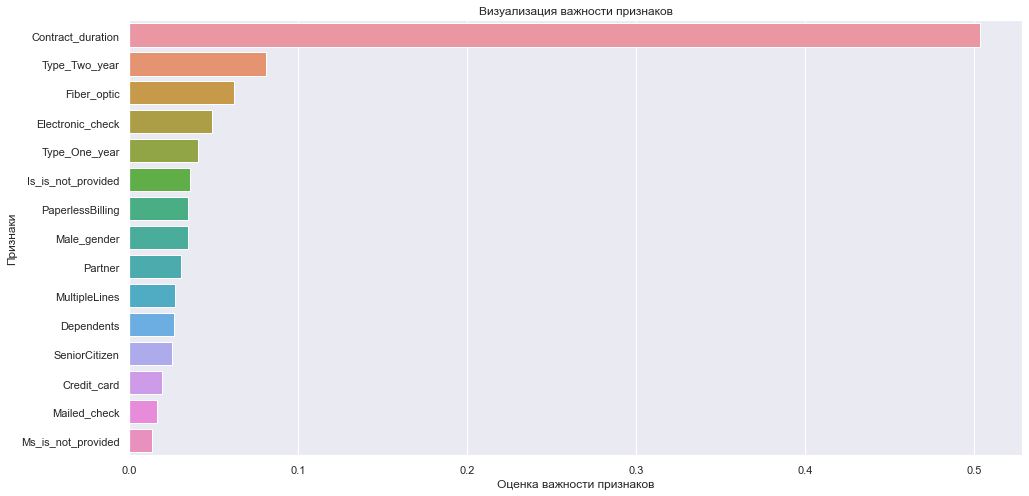

In [73]:
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=features_test.columns).sort_values(ascending=False)

    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')

chart_feature_imp(model_RF)
![image.png](attachment:image.png)

Итак, dозьмем для анализа только столбцы

- 'Contract_duration',
- 'Type_Two_year',
- 'Fiber_optic'.

In [74]:
features_train = features_train.drop(['Electronic_check', 'Type_One_year', 'Is_is_not_provided',
                                      'Male_gender', 'PaperlessBilling','Partner', 'Dependents','MultipleLines',
                                      'SeniorCitizen', 'Credit_card', 'Mailed_check', 'Ms_is_not_provided',
                                      'Electronic_check'], axis = 1)

features_test = features_test.drop(['Electronic_check', 'Type_One_year', 'Is_is_not_provided',
                                      'Male_gender', 'PaperlessBilling','Partner', 'Dependents','MultipleLines',
                                      'SeniorCitizen', 'Credit_card', 'Mailed_check', 'Ms_is_not_provided',
                                      'Electronic_check'], axis = 1)

In [75]:
pipe = Pipeline([('classifier' , RandomForestClassifier())])

param_grid = [{'classifier': [LogisticRegression()],
               'classifier__penalty' : ['l1', 'l2'],
               'classifier__class_weight' : ['balanced'],
               'classifier__random_state' : [12345],
               'classifier__C' : np.logspace(0.1, 1, 10),
               'classifier__solver' : ['liblinear']},
              {'classifier': [RandomForestClassifier()],
               'classifier__class_weight' : ['balanced'],
               'classifier__random_state' : [12345],
               'classifier__n_estimators' : list(range(10, 201, 10))
              }]

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 10, verbose = True, n_jobs = -1)

best_clf = clf.fit(features_train, target_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


In [76]:
best_clf.best_estimator_.get_params()['classifier']

RandomForestClassifier(class_weight='balanced', n_estimators=20,
                       random_state=12345)

In [77]:
model_RF = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                  criterion='gini', max_depth=None, max_features='auto',
                                  max_leaf_nodes=None, min_impurity_decrease=0.0,
                                  min_impurity_split=None, min_samples_leaf=1,
                                  min_samples_split=2, min_weight_fraction_leaf=0.0,
                                  n_estimators=20, n_jobs=None, oob_score=False,
                                  random_state=12345, verbose=0, warm_start=False)

model_RF.fit(features_train, target_train)
predictions_test_RF = model_RF.predict(features_test)
probabilities_test = model_RF.predict_proba(features_test)
probabilities_one_test_RF = probabilities_test[:, 1]

In [78]:
model_metrics(target_test, predictions_test_RF, probabilities_one_test_RF)

auc_roc = roc_auc_score(target_test, probabilities_one_test_RF)
RandomForestClassifier_pipeline_after_importances_data = pd.DataFrame({'model': ['RandomForestClassifier_pipeline_after_importances'], 'AUC-ROC': [auc_roc]})
display (RandomForestClassifier_pipeline_after_importances_data)

Полнота: 0.8328981723237598
Точность: 0.7168539325842697
Accuracy: 0.8649609097370291
F1-мера: 0.7705314009661836
AUC-ROC: 0.8549256486618799
AUC-ROC (predict_proba): 0.927359558583551


,model,AUC-ROC
0,RandomForestClassifier_pipeline_after_importances,0.92736


## Машинное обучение (градиентный бустинг)

Вернемся к датафрейму data_old до преобразования категориальных признаков и до разбиения данных на выборки.

Но вспомним, что мы приняли решение убрать признак MonthlyCharges из-за достаточно высокой корреляции.

In [79]:
data_old = data_old.drop(['MonthlyCharges'], axis=1)

print('Посмотрим на первые 5 строк датафрейма data_old:')
display(data_old.head())
print('')
print('')
print('Посмотрим общую информацию о датафрейме применив метод .info()')
display(data_old.info())

Посмотрим на первые 5 строк датафрейма data_old:


,Type,PaperlessBilling,PaymentMethod,Сontract_no_terminated,Contract_duration,gender,SeniorCitizen,Partner,Dependents,InternetService,MultipleLines
customerID,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,0.0,31.0,Female,0,Yes,No,DSL,service_is_not_provided
5575-GNVDE,One year,No,Mailed check,0.0,1036.0,Male,0,No,No,DSL,No
3668-QPYBK,Month-to-month,Yes,Mailed check,1.0,61.0,Male,0,No,No,DSL,No
7795-CFOCW,One year,No,Bank transfer (automatic),0.0,1371.0,Male,0,No,No,DSL,service_is_not_provided
9237-HQITU,Month-to-month,Yes,Electronic check,1.0,61.0,Female,0,No,No,Fiber optic,No




Посмотрим общую информацию о датафрейме применив метод .info()
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Type                    7032 non-null   object 
 1   PaperlessBilling        7032 non-null   object 
 2   PaymentMethod           7032 non-null   object 
 3   Сontract_no_terminated  7032 non-null   float64
 4   Contract_duration       7032 non-null   float64
 5   gender                  7032 non-null   object 
 6   SeniorCitizen           7032 non-null   int64  
 7   Partner                 7032 non-null   object 
 8   Dependents              7032 non-null   object 
 9   InternetService         7032 non-null   object 
 10  MultipleLines           7032 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 917.3+ KB


None

### Обучающая и тестовая выборки

Повторим процедуру разбиения данных на выборки.

In [80]:
features_date_old = data_old.drop(['Сontract_no_terminated'], axis=1)
target_date_old = data_old['Сontract_no_terminated']

features_train_date_old, features_test_date_old, target_train_date_old, target_test_date_old = train_test_split(
    features_date_old, target_date_old, test_size = 0.2, random_state = 12345)

Посмотрим на размер сформировавшихся выборок.

In [81]:
display('Размер обучающей выборки features_train_date_old:', features_train_date_old.shape)
display('Размер обучающей выборки с целевым признаком target_train_date_old:', target_train_date_old.shape)

display('Размер тестовой выборки features_train_date_old:', features_test_date_old.shape)
display('Размер тестовой выборки с целевым признаком target_train_date_old:', target_test_date_old.shape)

'Размер обучающей выборки features_train_date_old:'

(5625, 10)

'Размер обучающей выборки с целевым признаком target_train_date_old:'

(5625,)

'Размер тестовой выборки features_train_date_old:'

(1407, 10)

'Размер тестовой выборки с целевым признаком target_train_date_old:'

(1407,)

### CatBoostClassifier

Обучим модель CatBoostClassifier. Поскольку у нас задача классификации, укажем логистическую функцию потерь.

Помимо целевого признака и признаков, передадим моделе категориальные признаки.

In [82]:
cat_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender',
                'Partner', 'Dependents', 'InternetService', 'MultipleLines']

model_CBC = CatBoostClassifier(
    loss_function = "Logloss",
    iterations = 50,
    random_seed = 12345,
    learning_rate = 0.2)

model_CBC.fit(features_train_date_old, target_train_date_old, cat_features = cat_features, verbose = 10)

probabilities_test = model_CBC.predict_proba(features_test_date_old)
probabilities_one_test_CBC = probabilities_test[:, 1]

0:	learn: 0.6280003	total: 192ms	remaining: 9.4s
10:	learn: 0.4237072	total: 619ms	remaining: 2.19s
20:	learn: 0.3958561	total: 1.03s	remaining: 1.42s
30:	learn: 0.3841004	total: 1.39s	remaining: 850ms
40:	learn: 0.3752353	total: 1.77s	remaining: 388ms
49:	learn: 0.3695478	total: 2.16s	remaining: 0us


In [83]:
auc_roc = roc_auc_score(target_test_date_old, probabilities_one_test_CBC)
CatBoostClassifier_data = pd.DataFrame({'model': ['CatBoostClassifier'], 'AUC-ROC': [auc_roc]})
display (CatBoostClassifier_data)

,model,AUC-ROC
0,CatBoostClassifier,0.876349


## Результаты исследования

### Полученные значения метрик

Наилучшие значения метрики AUC-ROC нам показали следующие модели:

In [84]:
pd.concat([DecisionTreeClassifier_data, RandomForestClassifier_data, LogisticRegression_data,
           RandomForestClassifier_pipeline_data, RandomForestClassifier_pipeline_after_importances_data,
           CatBoostClassifier_data], ignore_index = True)

,model,AUC-ROC
0,DecisionTreeClassifier,0.735652
1,RandomForestClassifier,0.820596
2,LogisticRegression,0.846079
3,RandomForestClassifier_pipeline,0.820180
4,RandomForestClassifier_pipeline_after_importances,0.927360
5,CatBoostClassifier,0.876349


Нам удалось достичь метрики качества AUC-ROC 0.927360 с помощью модели машинного обучения RandomForestClassifier при использования подбора параметров GridSearchCV и с помощью запуска Pipeline, а также учитывая важность признаков для обучения модели.

Считаем, поставленная задача достигнута.

### Исследование зависимостей

Посмотрим, какие клиенты уходят чаще.

Напомним:

    - значение 1 в столбце 'EndDate' означает, что клиент все еще обслуживается в компании,
    - а значение 0 - означает, что клиент расторгнул договор.

In [85]:
data_old.groupby('Сontract_no_terminated').mean()

,Contract_duration,SeniorCitizen
Сontract_no_terminated,,
0.0,1146.885532,0.128995
1.0,547.352060,0.254682


Явных зависимостей не наблюдается.

In [86]:
data_old.groupby('Type').mean()

,Сontract_no_terminated,Contract_duration,SeniorCitizen
Type,,,
Month-to-month,0.427097,549.605161,0.208258
One year,0.112772,1281.447011,0.129076
Two year,0.028487,1737.899703,0.086053


Отразим общее распределение.

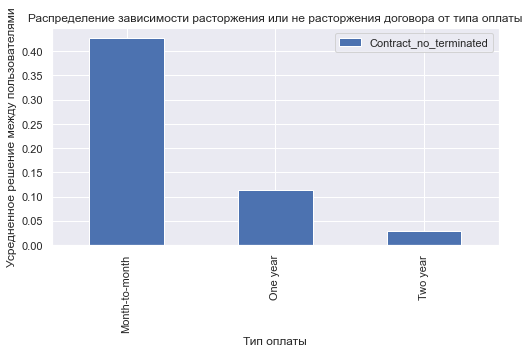

In [87]:
data_old.groupby('Type').mean().plot(
    y = 'Сontract_no_terminated',
    kind='bar',
    figsize=(8, 4),
    grid=True
)
plt.title('Распределение зависимости расторжения или не расторжения договора от типа оплаты')
plt.xlabel('Тип оплаты')
plt.ylabel('Усредненное решение между пользователями')
plt.show()

Можно предположить, что пользователи реже расторгают договор оказания услуг при оплате 1 раз в год или 1 раз в два года. При этом наблюдается увеличение числа людей, кто расторгает договор среди клиентов, кто оплачивает услуги каждый месяц.

На самом деле, здесь нет явного решения. Бизнесу следует исследовать это направление.

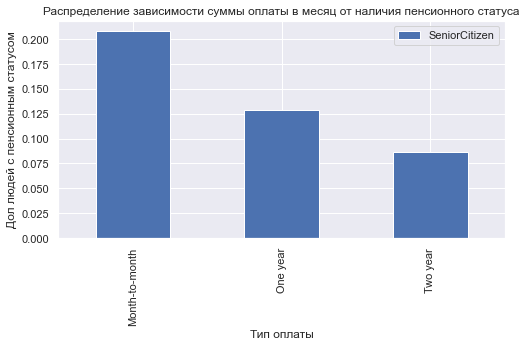

In [88]:
data_old.groupby('Type').mean().plot(
    y = 'SeniorCitizen',
    kind='bar',
    figsize=(8, 4),
    grid=True
)
plt.title('Распределение зависимости суммы оплаты в месяц от наличия пенсионного статуса')
plt.xlabel('Тип оплаты')
plt.ylabel('Дол людей с пенсионным статусом')
plt.show()

Здесь наблюдается зависимость, клиенты с пенсионным статусом чаще предпочитают тип оплаты Month-to-month.

Это знание можно учесть, как рекомендацию, какой тип оплаты предлагать клиентам с пенсионным статусом.

In [89]:
data_old.groupby('PaperlessBilling').mean()

,Сontract_no_terminated,Contract_duration,SeniorCitizen
PaperlessBilling,,,
No,0.163757,983.276536,0.092877
Yes,0.335893,990.467131,0.210173


Наблюдается небольшая зависимость, безналичный расчет предпочитает чуть большее число клиентов с пенсионным статусом.

В остальном признак PaperlessBilling не находит явного разделения между клиентами.

In [90]:
data_old.groupby('PaymentMethod').mean()

,Сontract_no_terminated,Contract_duration,SeniorCitizen
PaymentMethod,,,
Bank transfer (automatic),0.167315,1331.241894,0.151102
Credit card (automatic),0.152531,1318.641026,0.145299
Electronic check,0.452854,766.827484,0.251163
Mailed check,0.192020,668.576060,0.058603


Отразим распределения.

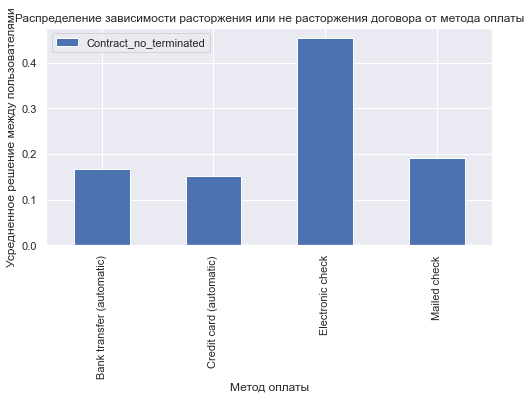

In [91]:
data_old.groupby('PaymentMethod').mean().plot(
    y = 'Сontract_no_terminated',
    kind='bar',
    figsize=(8, 4),
    grid=True
)
plt.title('Распределение зависимости расторжения или не расторжения договора от метода оплаты')
plt.xlabel('Метод оплаты')
plt.ylabel('Усредненное решение между пользователями')
plt.show()

По некоторым причинам доля клиентов, методом оплаты которых является электронный чек, которые расторгают договор больше, чем доля клиентов с прочими методами оплаты.

Возможно, на это тоже стоит обратить внимание.

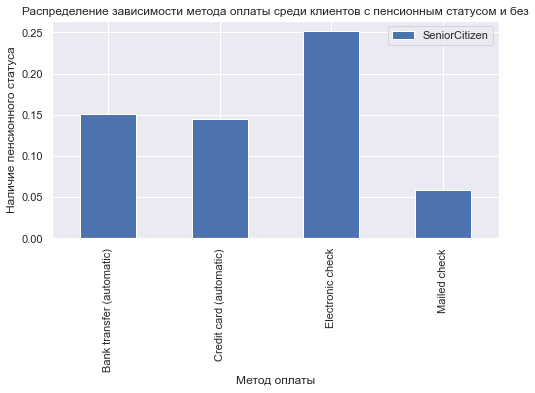

In [92]:
data_old.groupby('PaymentMethod').mean().plot(
    y = 'SeniorCitizen',
    kind='bar',
    figsize=(8, 4),
    grid=True
)
plt.title('Распределение зависимости метода оплаты среди клиентов с пенсионным статусом и без')
plt.xlabel('Метод оплаты')
plt.ylabel('Наличие пенсионного статуса')
plt.show()

Большинство клиентов с пенсионным статусом выбирают метод оплаты - электронный чек. Вспомним также, что такие клиенты в общем предпочитают безналичный расчет. Бизнесу стоит обратить на это внимание.

При этом реже всего пенсионеры пользуются способом оплаты - отправка чека.

In [93]:
data_old.groupby('gender').mean()

,Сontract_no_terminated,Contract_duration,SeniorCitizen
gender,,,
Female,0.269595,983.549239,0.163078
Male,0.262046,991.453649,0.161736


Зависимость не наблюдается.

In [94]:
data_old.groupby('SeniorCitizen').mean()

,Сontract_no_terminated,Contract_duration
SeniorCitizen,,
0,0.236503,982.396774
1,0.416813,1014.057793


Пенсионеры немногим реже расторгают договор, чем клиенты без пенсионного статуса. Не явный признак.

Пенсионеры платят в месяц в среднем больше, чем клиенты без пенсионного статуса.

Для бизнеса, конечно, это хороший показатель: пенсионеры уходят из компании реже, платят больше. Возможно, стоит поработать в этом направлении и адаптировать свои предложения с учетом этих наблюдений.а

In [95]:
data_old.groupby('Partner').mean()

,Сontract_no_terminated,Contract_duration,SeniorCitizen
Partner,,,
No,0.329761,712.015938,0.156362
Yes,0.197171,1283.037135,0.168877


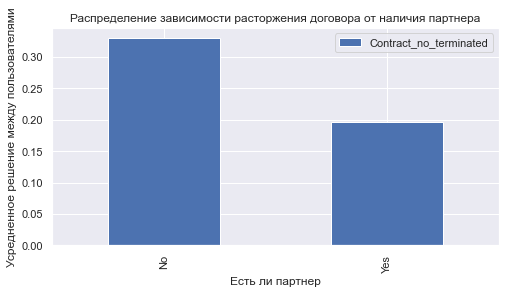

In [96]:
data_old.groupby('Partner').mean().plot(
    y = 'Сontract_no_terminated',
    kind='bar',
    figsize=(8, 4),
    grid=True
)
plt.title('Распределение зависимости расторжения договора от наличия партнера')
plt.xlabel('Есть ли партнер')
plt.ylabel('Усредненное решение между пользователями')
plt.show()

По нашим данным наблюдается небольшое преобладание числа клиентов, кто расторгает договор, при условии, что у клиента нет партнера (супруга/супруги). Имеет смысл сделать более интересные предложения для таких пользователей.

In [97]:
data_old.groupby('Dependents').mean()

,Сontract_no_terminated,Contract_duration,SeniorCitizen
Dependents,,,
No,0.312791,907.887087,0.213055
Yes,0.155312,1174.732730,0.043354


Мы наблюдаем здесь зависимость между наличием иждивенцев у людей с отсутствием пенсионного статуса. Это логично.
Скорее всего это неважный признак для бизнеса.

Также, при отсутствии иждивенцев в среднем клиенты платят большую сумму в месяц.
Стоит скорректировать предложения для клиентов с детьми.

Но при этом, несмотря на наличие иждивенцев, клиенты с детьми реже склоны к расторжению договора, нежели клиенты без детей.

### На каких клиентов бизнесу стоит обратить внимание

Чем реже пользователь платит за услуги: раз в год и раз в 2 года, - тем маловероятнее он решит расторгнуть договор.

Клиенты с пенсионным статусом в сравнении с клиентами без пенсионного статуса реже расторгают договоры оказания услуг. При этом в основном клиенты с пенсионным статусом предпочитают тип оплаты за каждым месяц.
Немаловажным показателем является и то, что клиенты с пенсионным статусом предпочитают безналичный расчет, а именно - оплату с помощью электронного чека, в отличие от клиентов без пенсионного статуса. Клиенты со статусом пенсионера платят в среднем в месяц больше, а уходят из компании реже.

Также, если исследовать вопрос о методе оплаты - число клиентов, методом оплаты которых является электронный чек, расторгают договор чаще, чем клиенты с прочими методами оплаты.

Клиенты, кто состоит в отношениях - имеет супруга/супругу реже расторгают договор, чем клиенты без партнера.
Стоит сделать специальные предложения для клиентов без пары, если задаться целью удержать их.

А при наличии детей (иждивенцев) клиенты платят немного меньшую сумму в месяц, чем клиенты без детей.
Стоит задуматься об интересном предложении для клиентов с детьми. Поскольку, несмотря на наличие иждивенцев, клиенты с детьми реже склоны к расторжению договора, нежели клиенты без детей.

## Отчет о проделанной работе

### Успешность выполнения проекта относительно плана работы

Все пункты плана были выполнены. Более того, с помощью дополнительного пункта, который возник в ходе работы, и который отражен в оглавлении проекта - Создание нового признака, - удалось достичь максимально возможного качества модели.

Мы успешно провели предобработку и исследовательский анализ данных на первых этапах. выявили и устранили недочеты в данных, обработали данные и привели их к лучшему виду, с которым могли бы поработать модели машинного обучения.

Мы соединили воедино четыре набора данных, скорректировали записи в итоговом датафрейме. Обработали категориальные признаки.

На следующем этапе мы разбили данные для того, чтобы на 80% их обучить модели, а на 20% провести тест и проверить метрики качества. Обработали численные признаки после разбиения на обучающей выборке при помощи метода стандартизации признаков.

Затем мы обучили три модели DecisionTreeClassifier, RandomForestClassifier и LogisticRegression.
Смогли получить значение метрики для модели LogisticRegression: 0.858469.
Но мы не остановились на этом этапе. Нам удалось достичь метрики качества AUC-ROC 0.943708 с помощью модели машинного обучения RandomForestClassifier при использовании подбора параметров GridSearchCV и с помощью запуска Pipeline, а также учитывая важность признаков для обучения модели.

После вывода всех результатов обучения для каждой из используемых моделей, мы подготовили развернутый вывод, а также дли некоторые рекомендации бизнесу: на что обратить внимание, на каких пользователей, на какие их характеристики/признаки.

Наши рекомендации могут помочь бизнес скорректировать свои предложения для клиентов, уменьшите % оттока клиентов, и наверняка, при грамотной аналитической работе, повысить прибыль.

Считаем, за поставленная задача успешно нами выполнена.

### Что касается трудностей 

На этапе предобработки данных, было выявлено, что несколько записей в датафреме "Информация о договоре: contract.csv", в столбце 'TotalCharges' были заполнены странным образом. Ожидаемые значения, которые предполагаются в этом случае - NAN, NULL, 0 или пропуск не подходили. Опытном путем было выявлено, что 11 записей содержат два пробела (space) в столбце 'TotalCharges'. Это были данные о новых клиентах, которые только пришли в компанию. Нам удалось их идентифицировать и скорректировать данные, чтобы избежать ошибок.

Также, на этапе создания нового признака - Срок действия контракта, - который подсчитывался как разница между данными в столбацах 'EndDate' и 'BeginDate', мы столкнулись с проблемой: что указывать для клиентов, кто все еще остается клиентом компании? Посоветовавшись с коллегой, было принято решение во избежание переобучения модели, толковать новый признак, как срок действия контракта на момент сбора данных. В этом случае для тех клиентов, кто не ушел из компании, срок действия контракта указывался как количество дней между датой заключения договора и датой сбора данных: 1 февраля 2020 года.

Все трудности, которые возникали по мере работы над проектом, были успешно проработаны.

### Ключевые шаги в решении задачи

Главными пунктами нашего проекта можно выделить следующие шаги:

    - Изучение и предобработка данных
    - исследовательский анализ данных
    - Слияние датафреймов
    - Подготовка обучающей и тестовой выборки
    - Обучение моделей машинного обучения
    - Выводы и результаты исследования
    
### Итоговая модель и ее качество

In [98]:
pd.concat([DecisionTreeClassifier_data, RandomForestClassifier_data, LogisticRegression_data,
           RandomForestClassifier_pipeline_data, RandomForestClassifier_pipeline_after_importances_data,
           CatBoostClassifier_data], ignore_index = True)

,model,AUC-ROC
0,DecisionTreeClassifier,0.735652
1,RandomForestClassifier,0.820596
2,LogisticRegression,0.846079
3,RandomForestClassifier_pipeline,0.820180
4,RandomForestClassifier_pipeline_after_importances,0.927360
5,CatBoostClassifier,0.876349


Нам удалось достичь метрики качества AUC-ROC 0.927360 с помощью модели машинного обучения **RandomForestClassifier** при использовании подбора параметров **GridSearchCV** и с помощью запуска **Pipeline**, а также учитывая **важность признаков** для обучения модели.